In [102]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

# model
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, OneVsRest

# evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

## **LOAD DATASET**

In [104]:
spark = SparkSession.builder \
    .appName("Diabetes Classification") \
    .getOrCreate()

data = spark.read.csv("/dataset/diabetes.csv", header=True, inferSchema=True)
data.show(5)

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
only showing top 5 rows



## **PREPROCESSING**

In [105]:
# tipe data
data.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)



In [106]:
# memeriksa null
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+
|gender|age|hypertension|heart_disease|smoking_history|bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+
|     0|  0|           0|            0|              0|  0|          0|                  0|       0|
+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+



In [107]:
# melihat unique value dan distribusi data pada kolom gender dan smoking history
print("Distribusi Data:")
data.groupBy('gender').count().show()
data.groupBy('smoking_history').count().show()

Distribusi Data:
+------+-----+
|gender|count|
+------+-----+
|Female|58552|
| Other|   18|
|  Male|41430|
+------+-----+

+---------------+-----+
|smoking_history|count|
+---------------+-----+
|    not current| 6447|
|         former| 9352|
|        No Info|35816|
|        current| 9286|
|          never|35095|
|           ever| 4004|
+---------------+-----+



In [108]:
# membuang data pada kolom gender yang memilki nilai Other
data = data.filter(col("gender") != "Other")

In [109]:
# merubah tipe data

# Membuat indexer untuk kolom yang ingin di-encode
indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_temp")
    for column in ["gender", "smoking_history"]
]

for indexer in indexers:
    data = indexer.fit(data).transform(data)

# Drop kolom asli dan rename kolom temporary
for column in ["gender", "smoking_history"]:
    data = data.drop(column).withColumnRenamed(column+"_temp", column)

In [110]:
# menampilkan data setelah di encode
data.show(5)

+----+------------+-------------+-----+-----------+-------------------+--------+------+---------------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|gender|smoking_history|
+----+------------+-------------+-----+-----------+-------------------+--------+------+---------------+
|80.0|           0|            1|25.19|        6.6|                140|       0|   0.0|            1.0|
|54.0|           0|            0|27.32|        6.6|                 80|       0|   0.0|            0.0|
|28.0|           0|            0|27.32|        5.7|                158|       0|   1.0|            1.0|
|36.0|           0|            0|23.45|        5.0|                155|       0|   0.0|            3.0|
|76.0|           1|            1|20.14|        4.8|                155|       0|   1.0|            3.0|
+----+------------+-------------+-----+-----------+-------------------+--------+------+---------------+
only showing top 5 rows



In [111]:
print("Unique values di gender:")
data.select('gender').distinct().show()

print("Unique values di smoking_history:")
data.select('smoking_history').distinct().show()

Unique values di gender:
+------+
|gender|
+------+
|   0.0|
|   1.0|
+------+

Unique values di smoking_history:
+---------------+
|smoking_history|
+---------------+
|            0.0|
|            1.0|
|            4.0|
|            3.0|
|            2.0|
|            5.0|
+---------------+



In [112]:
# menampilkan summary
data.describe().show()

+-------+------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+
|summary|               age|       hypertension|      heart_disease|               bmi|       HbA1c_level|blood_glucose_level|           diabetes|             gender|   smoking_history|
+-------+------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+
|  count|             99982|              99982|              99982|             99982|             99982|              99982|              99982|              99982|             99982|
|   mean| 41.88807585365379| 0.0748634754255766|0.03942709687743794|27.320756536170723| 5.527528955210267| 138.05781040587306|0.08501530275449581|0.41437458742573663|1.2744794062931328|
| stddev|22.517206453904386|0.26317224054552874|0.19460981400544944| 6

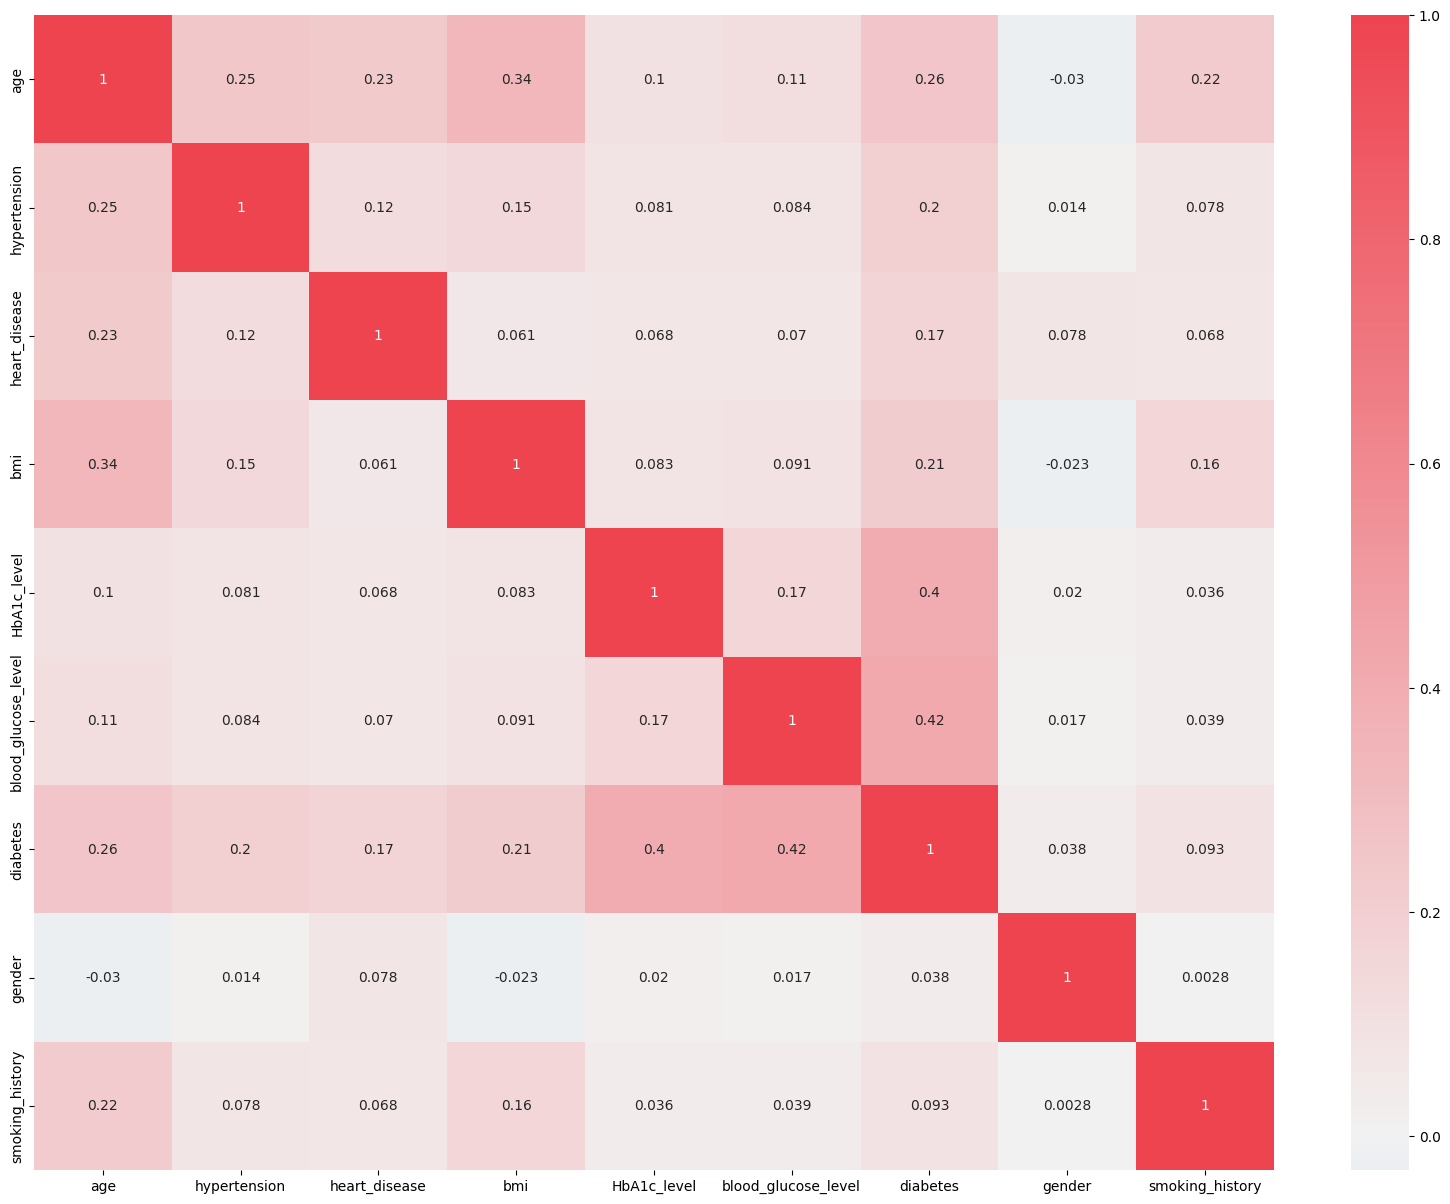

In [113]:
# korelasi matrix
pandas_data = data.toPandas()
corrmat = pandas_data.corr()
plt.figure(figsize=(20, 15))
cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)
plt.show()

## **EDA**

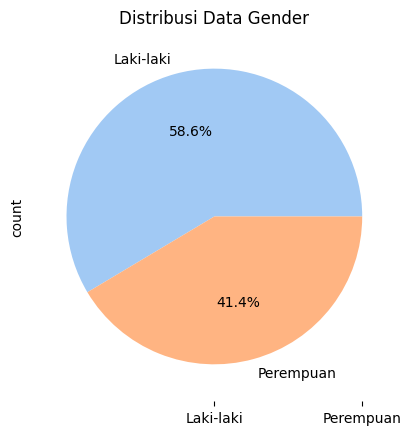

In [114]:
# Pie Chart
pandas_data['gender'].value_counts().plot.pie(autopct="%1.1f%%",
                                              labels=["Laki-laki", "Perempuan"],
                                              colors=sns.color_palette('pastel'))
plt.title("Distribusi Data Gender")
# Mengganti label sumbu x
plt.xticks(ticks=[0, 1], labels=["Laki-laki", "Perempuan"])
plt.show()

<ipython-input-115-b29e7047320c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_data, x="smoking_history", palette='pastel')


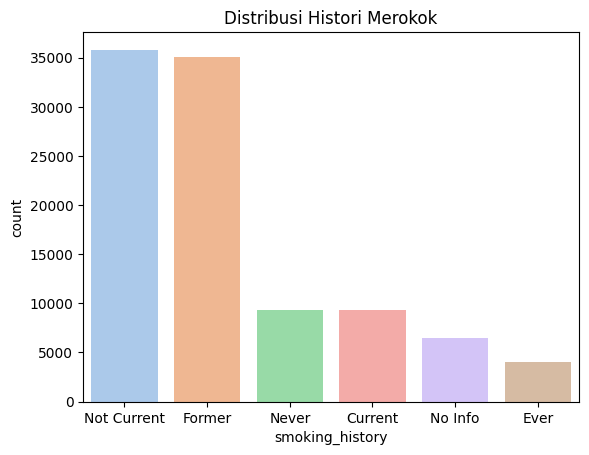

In [115]:
# Bar Chart
sns.countplot(data=pandas_data, x="smoking_history", palette='pastel')
plt.title("Distribusi Histori Merokok")

plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=["Not Current", "Former", "Never", "Current", "No Info", "Ever"])
plt.show()

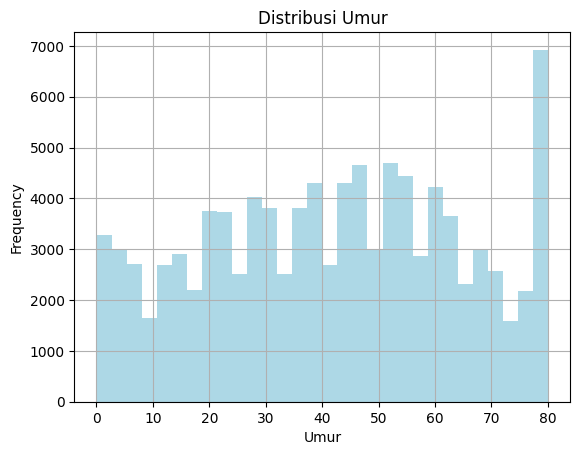

In [116]:
# Histogram
pandas_data["age"].hist(bins=30, color='lightblue')
plt.title("Distribusi Umur")
plt.xlabel("Umur")
plt.ylabel("Frequency")
plt.show()

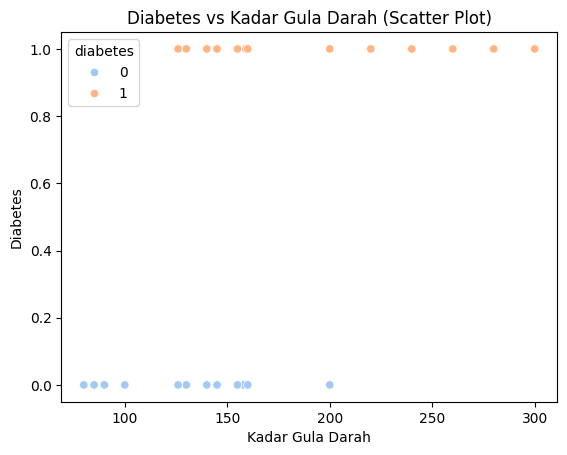

In [117]:
# Scatter Plot
sns.scatterplot(data=pandas_data, x="blood_glucose_level", y="diabetes", hue="diabetes", palette='pastel')
plt.title("Diabetes vs Kadar Gula Darah (Scatter Plot)")
plt.xlabel("Kadar Gula Darah")
plt.ylabel("Diabetes")
plt.show()

## **FEATURE SELECTION**

In [118]:
# List feature
feature_columns = ["age", "hypertension", "heart_disease", "bmi", "blood_glucose_level", "HbA1c_level"]

# Menggabungkan fitur menjadi satu vektor
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [119]:
# Transform data numerik
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

In [120]:
# Split data
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

## **MODEL**

In [121]:
# Membuat 4 model [Logistic Regression, Decision Tree, Random Forest, XGBoost]
lr = LogisticRegression(labelCol="diabetes", featuresCol="scaled_features")
dt = DecisionTreeClassifier(labelCol="diabetes", featuresCol="scaled_features")
rf = RandomForestClassifier(labelCol="diabetes", featuresCol="scaled_features")
gbt = GBTClassifier(labelCol="diabetes", featuresCol="scaled_features")

In [122]:
ovr_gbt = OneVsRest(classifier=gbt, labelCol="diabetes")

In [123]:
# Mmebuat pipeline
pipelines = [
    Pipeline(stages=[vector_assembler, scaler, lr]),
    Pipeline(stages=[vector_assembler, scaler, dt]),
    Pipeline(stages=[vector_assembler, scaler, rf]),
    Pipeline(stages=[vector_assembler, scaler, ovr_gbt])
]

## **MATRIX EVALUASI**

In [124]:
# Model evaluasi
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="diabetes", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="diabetes", predictionCol="prediction", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="diabetes", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="diabetes", predictionCol="prediction", metricName="weightedRecall")

In [126]:
# Latih Model
for pipeline in pipelines:
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)

    accuracy = accuracy_evaluator.evaluate(predictions)
    f1_score = f1_evaluator.evaluate(predictions)
    precision = precision_evaluator.evaluate(predictions)
    recall = recall_evaluator.evaluate(predictions)

    model_name = pipeline.getStages()[-1].__class__.__name__
    print(f"Model: {model_name}, Accuracy: {accuracy:.2f}, F1 Score: {f1_score:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

    if isinstance(pipeline.getStages()[-1], OneVsRest):
        for label in data.select("diabetes").distinct().collect():
            label_value = label.diabetes
            binary_predictions = predictions.withColumn("binary_prediction", when(col("prediction") == label_value, 1).otherwise(0))
            binary_evaluator = BinaryClassificationEvaluator(labelCol="binary_prediction", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
            auc = binary_evaluator.evaluate(binary_predictions)
            print(f"AUC for class {label_value}: {auc}")

Model: LogisticRegression, Accuracy: 0.96, F1 Score: 0.96, Precision: 0.96, Recall: 0.96
Model: DecisionTreeClassifier, Accuracy: 0.97, F1 Score: 0.97, Precision: 0.97, Recall: 0.97
Model: RandomForestClassifier, Accuracy: 0.97, F1 Score: 0.97, Precision: 0.97, Recall: 0.97
Model: OneVsRest, Accuracy: 0.97, F1 Score: 0.97, Precision: 0.97, Recall: 0.97
AUC for class 1: 1.0
AUC for class 0: 0.0


## **HYPERPARAMETER TUNNING**

In [127]:
# 2 Model terbaik
rf_pipeline = Pipeline(stages=[vector_assembler, scaler, rf])
gbt_pipeline = Pipeline(stages=[vector_assembler, scaler, ovr_gbt])

In [129]:
# Menentukan parameter grid untuk model Random Forest
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .build()

# Menentukan parameter grid untuk model Gradient Boosting
gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 5, 10]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="diabetes", predictionCol="prediction", metricName="accuracy")

rf_crossval = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=rf_paramGrid, evaluator=evaluator, numFolds=3)
rf_cvModel = rf_crossval.fit(train_data)

rf_predictions = rf_cvModel.transform(test_data)
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Best Model Accuracy after Tuning: {rf_accuracy:.2f}")

gbt_crossval = CrossValidator(estimator=gbt_pipeline, estimatorParamMaps=gbt_paramGrid, evaluator=evaluator, numFolds=3)
gbt_cvModel = gbt_crossval.fit(train_data)

gbt_predictions = gbt_cvModel.transform(test_data)
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosting Best Model Accuracy after Tuning: {gbt_accuracy:.2f}")

Random Forest Best Model Accuracy after Tuning: 0.97
Gradient Boosting Best Model Accuracy after Tuning: 0.97
